# Preamble

This tutorial depends on the NumPy, matplotlib, and intervaltree packages.

In [1]:
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting

from IPython.display import Audio

from intervaltree import Interval,IntervalTree

%matplotlib inline

In [2]:
import platform
print(platform.python_version())

3.5.2


### Constants

A recording of a musical performance is a real-valued time series. The values of this time series represent sound pressure variations sampled at regular intervals, in this case 44,100Hz. The human ear interprets pressure periodicities as musical notes.

In [3]:
fs = 44100      # samples/second

### Load MusicNet

Download MusicNet from http://homes.cs.washington.edu/~thickstn/musicnet.html

In [4]:
# python2では普通にこうやって開く
train_data = np.load(open('./musicnet.npz','rb'))

In [4]:
# python3では普通に開くとこの後で何らかのDecodeErrorになるが、下のようにひらけば大丈夫！(thanks to @marshi)
train_data = np.load(open('./musicnet.npz','rb'),encoding='latin1')

# Exploring MusicNet

MusicNet consists of 330 recordings. Each recording is indexed in train_data by a MusicNet id.

In [5]:
print('Number of recordings: ' + str(len(train_data.files)))
print('Example MusicNet ids: ' + str(train_data.keys()[0:5]))

Number of recordings: 330
Example MusicNet ids: ['1788', '1789', '2659', '2127', '1818']


Each item in MusicNet consists of both an audio time series X and a collection of labels Y.

In [6]:
X,Y = train_data['2494'] # data X and labels Y for recording id 2494

In [7]:
print(type(X))
print(type(Y))

<class 'numpy.ndarray'>
<class 'intervaltree.intervaltree.IntervalTree'>


The time series X is a floating point array of pressure samples, normalized to the interval [-1,1].

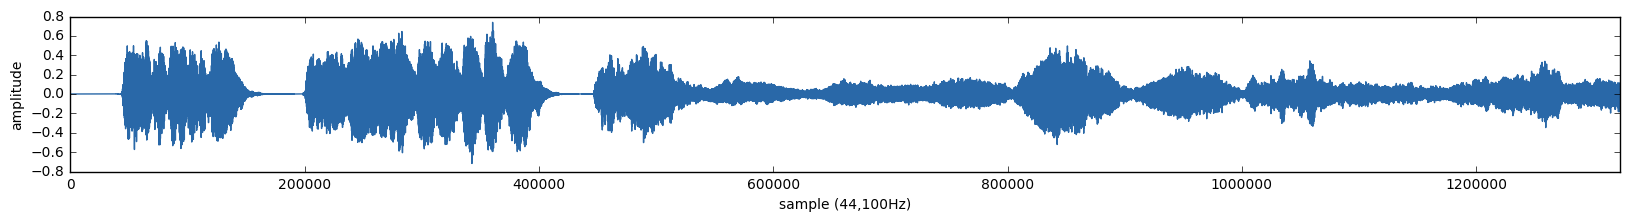

In [8]:
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(2)
plt.plot(X[0:30*fs],color=(41/255.,104/255.,168/255.))
fig.axes[0].set_xlim([0,30*fs])
fig.axes[0].set_xlabel('sample (44,100Hz)')
fig.axes[0].set_ylabel('amplitude')

We can play back this time series to hear what it sounds like.

In [11]:
Audio(X[0:30*fs],rate=fs)

The labels Y are a collection of intervals that indicate the presence of notes in the time series. For convenient access, these notes are stored in an intervaltree. This data structure offers efficient queries for intervals that intersect a particular query point in the time series. For example, we can ask how many notes are being played at time t = 5s in X.

In [13]:
print('Notes present at sample ' + str(fs*5) + ' (5 seconds): ' + str(len(Y[fs*5])))

Notes present at sample 220500 (5 seconds): 4


No notes are being played at time t = 4s (compare this to the plot of the time series X above).

In [14]:
print('Notes present at sample ' + str(fs*4) + ' (4 seconds): ' + str(len(Y[fs*4])))

Notes present at sample 176400 (4 seconds): 0


Each label consists of an interval (start_time,end_time), instrument and note codes, measure and beat, and the note's metrical duration (i.e. note value). 

In [15]:
(start,end,(instrument,note,measure,beat,note_value)) = sorted(Y[fs*5])[0]
print(' -- An example of a MusicNet label -- ')
print( ' Start Time:                          ' + str(start))
print (' End Time:                            ' + str(end))
print( ' Instrument (MIDI instrument code):   ' + str(instrument))
print( ' Note (MIDI note code):               ' + str(note))
print( ' Measure:                             ' + str(measure))
print( ' Beat (0 <= beat < 1):                ' + str(beat))
print( ' Note Value:                          ' + str(note_value))

 -- An example of a MusicNet label -- 
 Start Time:                          199134
 End Time:                            223198
 Instrument (MIDI instrument code):   41
 Note (MIDI note code):               55
 Measure:                             3
 Beat (0 <= beat < 1):                0.0
 Note Value:                          Quarter


# Visual Labels

We can construct a visual representation of an aligned score-performance pair by plotting the labels as a function of time.

In [16]:
stride = 512                         # 512 samples between windows
wps = fs/float(stride)               # ~86 windows/second
Yvec = np.zeros((int(30*wps),128))   # 128 distinct note labels
colors = {41 : .33, 42 : .66, 43 : 1}

for window in range(Yvec.shape[0]):
    labels = Y[window*stride]
    for label in labels:
        Yvec[window,label.data[1]] = colors[label.data[0]]

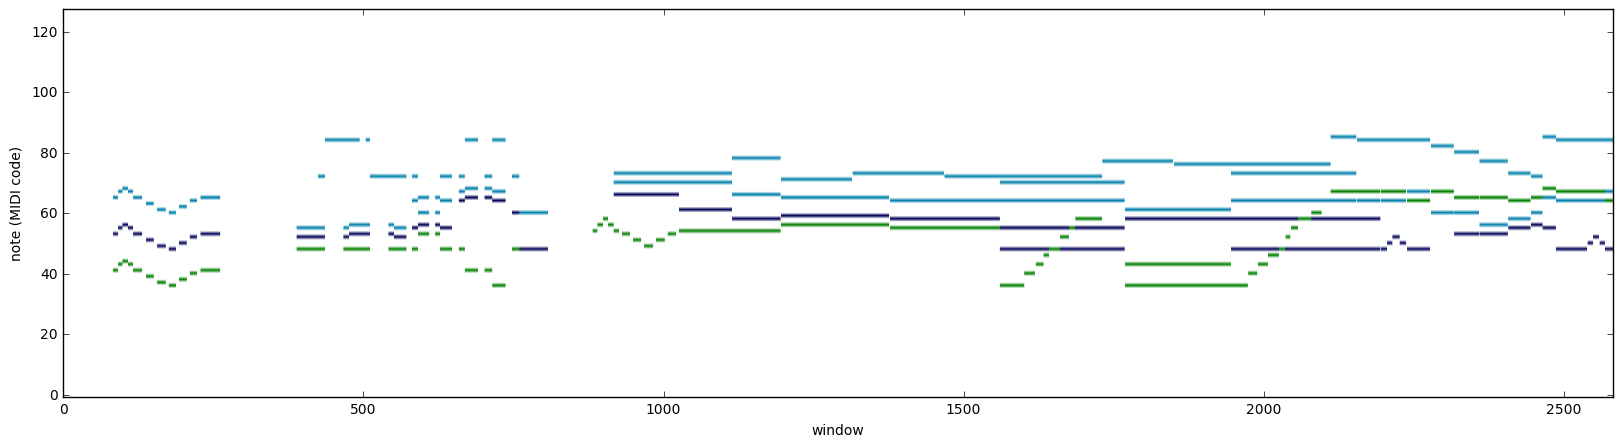

In [15]:
fig = plt.figure(figsize=(20,5))
plt.imshow(Yvec.T,aspect='auto',cmap='ocean_r')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('window')
fig.axes[0].set_ylabel('note (MIDI code)')

# Audio Labels

We also can construct an aural representation of an alignment by mixing a short sine wave into the performance for each note, with the frequency indicated by the score at the time indicated by the alignment. If the alignment is correct, the sine tones will exactly overlay the original performance; if the alignment is incorrect, the mix will sound dissonant.

In [17]:
mix_size=4096

labels = np.zeros(X.shape)
for (onset,offset,label) in sorted(Y):
    freq = 440.*2**((label[1] - 69.)/12.)
    mark = np.sin(freq*2.*np.pi*np.arange(0,mix_size)/float(fs))
    if onset + len(mark) < len(labels):
        labels[onset:onset+mix_size] += mark
        
labels /= np.max(labels)

mix = .8*labels + .2*X

In [18]:
Audio(mix[0:30*fs],rate=fs)